In [81]:
import pandas as pd
import numpy as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from sklearn.manifold import TSNE
from pandas.tools.plotting import andrews_curves
import os
from pandas.tools.plotting import parallel_coordinates
from pandas.tools.plotting import radviz
import scipy

In [105]:
#Modelling
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
import xgboost as xgb
import lightgbm as lgb
import warnings

In [106]:
os.chdir('/home/tapas/Financial_data/Final_data/auto/')

In [107]:
df = pd.read_csv('auto.csv')

In [108]:
df.shape

(1252, 12)

In [109]:
del df['Company.Name']
del df['EVEBITDA']
del df['P.E']
del df['P.B']

In [110]:
df.head(5)

,YEAR,ROE,ROC,NPM,DIV,DEP,Beta,PSALES
0,1991,46.00,24.52,20.09,10.34,15.3,0.28,2.990102
1,1991,23.23,9.76,11.77,0.00,35.5,0.59,0.872008
2,1991,1.70,0.69,0.97,0.00,62.0,0.96,0.259078
3,1991,2.74,1.11,1.46,0.00,62.4,0.96,0.152352
4,1991,16.91,1.10,7.10,0.00,1406.6,1.09,0.022791


# Feature Engineering

In [111]:
df["YEAR"] = df["YEAR"].astype("category")

In [112]:
# put ages in categories and add as columns to DataFrame
age_bins = [0, 1960, 1970, 1980, 1990,2000,2017]
age_labels = ["1", "2", "3", "4","5","6"]
df['YEAR'] = pd.cut(df['YEAR'], age_bins, labels=age_labels,right=True, include_lowest=True)

In [156]:
def multiplot(data,features,plottype,nrows,ncols,figsize,y=None,colorize=False):
    """ This function draw a multi plot for 3 types of plots ["regplot","distplot","coutplot"]"""
    n = 0
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    
    if colorize:
        colors = sns.color_palette(n_colors=(nrows*ncols))
    else :
        colors = [None]*(nrows*ncols)
        
    for row in range(ncols):
        for col in range(nrows):
            
            if plottype == 'regplot':
                if y == None:
                    raise ValueError('y value is needed with regplot type')
                
                sns.regplot(data = data, x = features[n], y = y ,ax=axes[row,col], color = colors[n])
                correlation = np.corrcoef(data[features[n]],data[y])[0,1]
                axes[row,col].set_title("Correlation {:.2f}".format(correlation))
            
            elif plottype == 'distplot':
                sns.distplot(a = data[features[n]],ax = axes[row,col],color=colors[n])
                skewness = data[features[n]].skew()
                axes[row,col].legend(["Skew : {:.2f}".format(skewness)])
            
            elif plottype in ['countplot']:
                g = sns.countplot(x = data[features[n]], y = y, ax = axes[row,col],color = colors[n])
                g = plt.setp(g.get_xticklabels(), rotation=45)
                
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

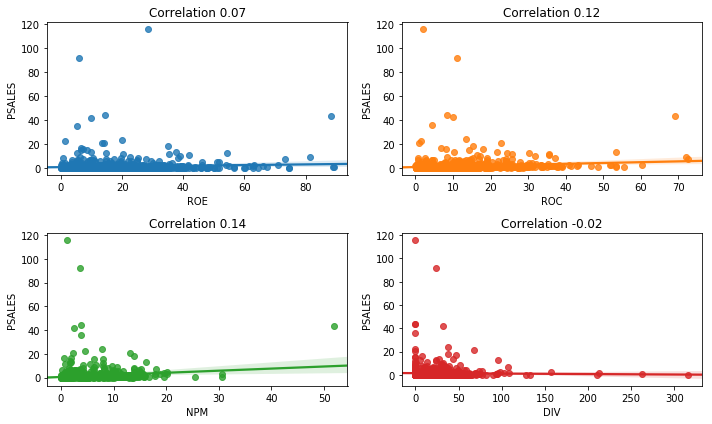

In [157]:
feats = ['ROE', 'ROC', 'NPM', 'DIV', 'DEP','Beta']

multiplot(data = df,features = feats,plottype = "regplot",nrows = 2, ncols = 2,
          figsize = (10,6),y = 'PSALES', colorize = True)

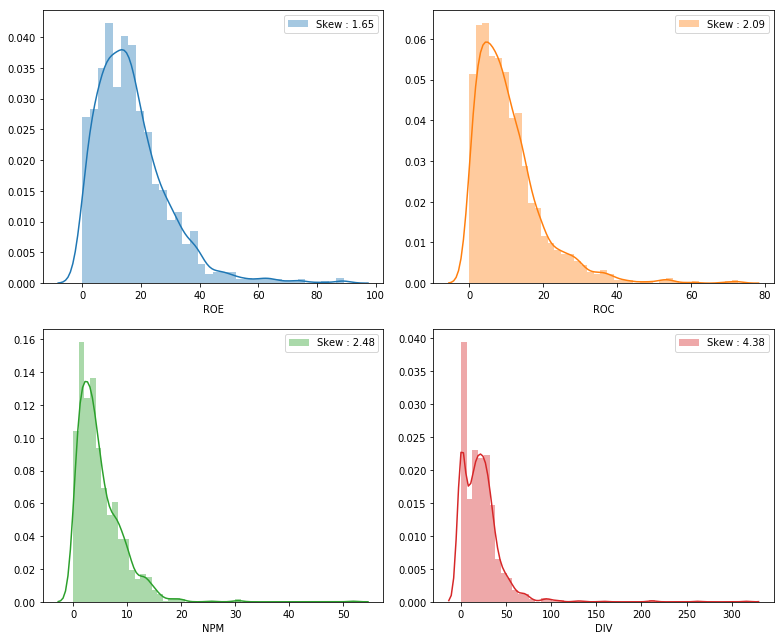

In [159]:
skewed_features = ['ROE', 'ROC', 'NPM', 'DIV', 'DEP','Beta']
multiplot(data = df,features = skewed_features,plottype = "distplot",
          nrows = 2, ncols = 2, figsize = (11,9), colorize = True)

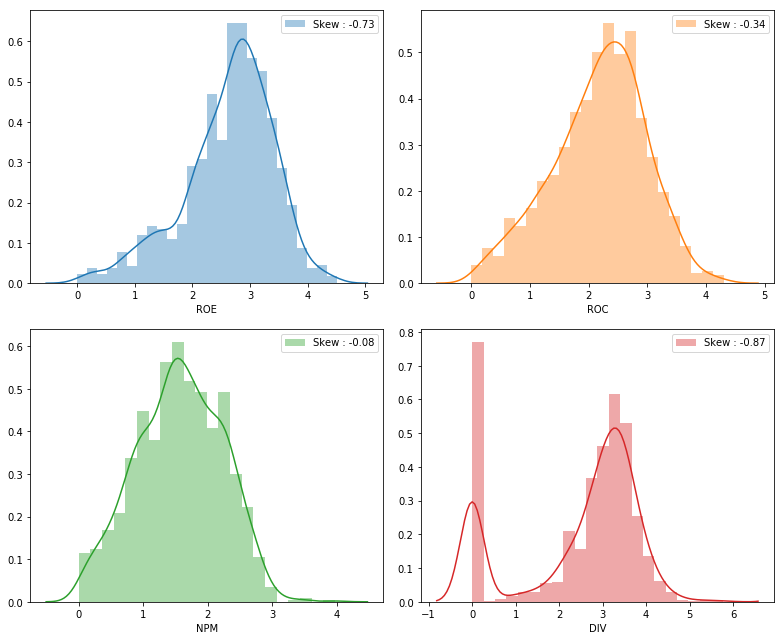

In [59]:
for feature in skewed_features:
    df[feature] = np.log1p(df[feature])
multiplot(data = df,features = skewed_features,plottype = "distplot",
          nrows = 2, ncols = 2, figsize = (11,9), colorize = True)

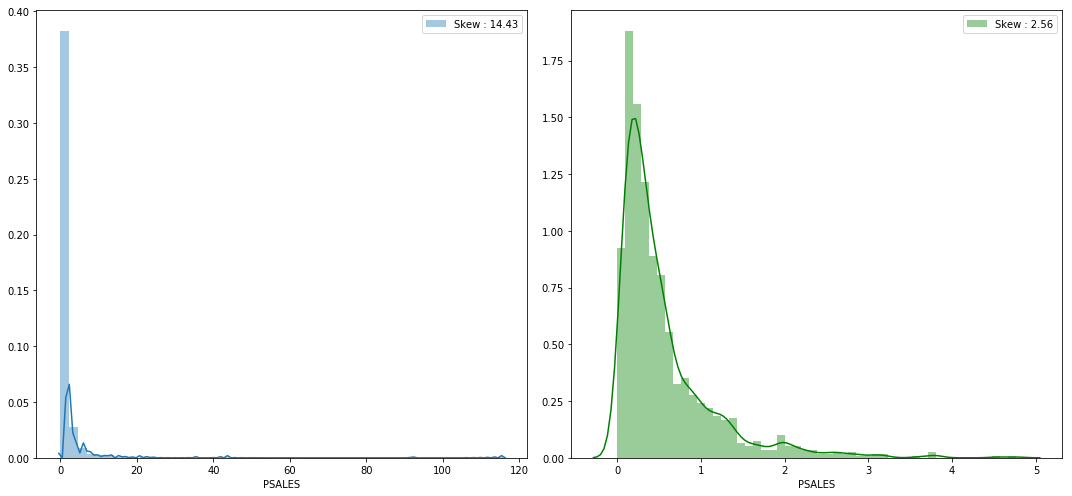

In [60]:
plt.figure(1)
fig, axes = plt.subplots(1,2,figsize=(15,7))

sns.distplot(df['PSALES'],ax = axes[0])
sns.distplot(np.log1p(df['PSALES']),ax = axes[1],color="g")

axes[0].legend(["Skew : {:.2f}".format(df['PSALES'].skew())])
axes[1].legend(["Skew : {:.2f}".format(np.log1p(df['PSALES']).skew())])

plt.tight_layout()
plt.show()
plt.gcf().clear()

In [116]:
t = df.iloc[:,1:7]

In [132]:
z= df.filter(['YEAR','PSALES'], axis=1)

In [127]:
list_ib = t.columns.values

for i in list_ib:
    for j in list_ib:
        if i == j:
            break
        else:
            new = t[i] * t[j]
            t['new_' + str(i) + '_' + str(j)] = new # Add new column which is the result of multiplying columns i and j together

In [134]:
t.head(5)

,ROE,ROC,NPM,DIV,DEP,Beta,new_ROC_ROE,new_NPM_ROE,new_NPM_ROC,new_DIV_ROE,...,new_DIV_NPM,new_DEP_ROE,new_DEP_ROC,new_DEP_NPM,new_DEP_DIV,new_Beta_ROE,new_Beta_ROC,new_Beta_NPM,new_Beta_DIV,new_Beta_DEP
0,46.00,24.52,20.09,10.34,15.3,0.28,1127.9200,924.1400,492.6068,475.64,...,207.7306,703.800,375.156,307.377,158.202,12.8800,6.8656,5.6252,2.8952,4.284
1,23.23,9.76,11.77,0.00,35.5,0.59,226.7248,273.4171,114.8752,0.00,...,0.0000,824.665,346.480,417.835,0.000,13.7057,5.7584,6.9443,0.0000,20.945
2,1.70,0.69,0.97,0.00,62.0,0.96,1.1730,1.6490,0.6693,0.00,...,0.0000,105.400,42.780,60.140,0.000,1.6320,0.6624,0.9312,0.0000,59.520
3,2.74,1.11,1.46,0.00,62.4,0.96,3.0414,4.0004,1.6206,0.00,...,0.0000,170.976,69.264,91.104,0.000,2.6304,1.0656,1.4016,0.0000,59.904
4,16.91,1.10,7.10,0.00,1406.6,1.09,18.6010,120.0610,7.8100,0.00,...,0.0000,23785.606,1547.260,9986.860,0.000,18.4319,1.1990,7.7390,0.0000,1533.194


In [136]:
df = pd.concat([t, z], axis = 1)

In [138]:
# Convert year to category
df['Age_1'] = df['YEAR'].map(lambda s: 1 if s == 1 else 0)
df['Age_2'] = df['YEAR'].map(lambda s: 2 if s == 2 else 0)
df['Age_3'] = df['YEAR'].map(lambda s: 3 if s == 3 else 0)
df['Age_4'] = df['YEAR'].map(lambda s: 4 if s == 4 else 0)
df['Age_5'] = df['YEAR'].map(lambda s: 5 if s == 5 else 0)
df['Age_6'] = df['YEAR'].map(lambda s: 6 if s ==6  else 0)
#df.drop(labels=["YEAR"],axis = 1,inplace=True)

In [139]:
df.head(5)

,ROE,ROC,NPM,DIV,DEP,Beta,new_ROC_ROE,new_NPM_ROE,new_NPM_ROC,new_DIV_ROE,...,new_Beta_DIV,new_Beta_DEP,YEAR,PSALES,Age_1,Age_2,Age_3,Age_4,Age_5,Age_6
0,46.00,24.52,20.09,10.34,15.3,0.28,1127.9200,924.1400,492.6068,475.64,...,2.8952,4.284,5,2.990102,0,0,0,0,0,0
1,23.23,9.76,11.77,0.00,35.5,0.59,226.7248,273.4171,114.8752,0.00,...,0.0000,20.945,5,0.872008,0,0,0,0,0,0
2,1.70,0.69,0.97,0.00,62.0,0.96,1.1730,1.6490,0.6693,0.00,...,0.0000,59.520,5,0.259078,0,0,0,0,0,0
3,2.74,1.11,1.46,0.00,62.4,0.96,3.0414,4.0004,1.6206,0.00,...,0.0000,59.904,5,0.152352,0,0,0,0,0,0
4,16.91,1.10,7.10,0.00,1406.6,1.09,18.6010,120.0610,7.8100,0.00,...,0.0000,1533.194,5,0.022791,0,0,0,0,0,0


# Explanotary Data Analysis

/root/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

'pandas.tools.plotting.andrews_curves' is deprecated, import 'pandas.plotting.andrews_curves' instead.



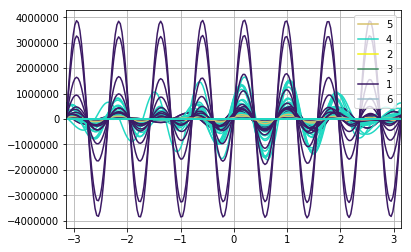

In [140]:
andrews_curves(df, 'YEAR')
plt.show()

/root/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

'pandas.tools.plotting.parallel_coordinates' is deprecated, import 'pandas.plotting.parallel_coordinates' instead.



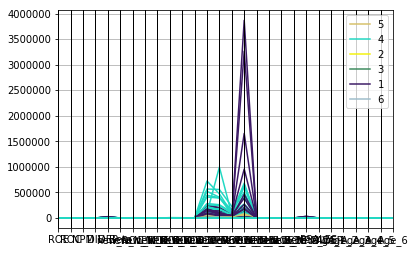

In [141]:
parallel_coordinates(df, 'YEAR')

/root/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

'pandas.tools.plotting.radviz' is deprecated, import 'pandas.plotting.radviz' instead.



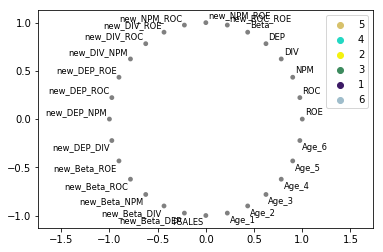

In [142]:
radviz(df, 'YEAR')

In [143]:
tsne = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=300,
    verbose=2,
    angle=0.5
)

In [144]:

# 17.2 Next, t-sne of titanic data
tsne_results = tsne.fit_transform(df.iloc[:, 1:], df.iloc[:, 0:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1252 samples in 0.006s...
[t-SNE] Computed neighbors for 1252 samples in 0.190s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1252
[t-SNE] Computed conditional probabilities for sample 1252 / 1252
[t-SNE] Mean sigma: 28.195580
[t-SNE] Computed conditional probabilities in 0.404s
[t-SNE] Iteration 50: error = 79.5855026, gradient norm = 0.4226904 (50 iterations in 10.257s)
[t-SNE] Iteration 100: error = 89.0241852, gradient norm = 0.3640977 (50 iterations in 7.985s)
[t-SNE] Iteration 150: error = 96.5635223, gradient norm = 0.3486547 (50 iterations in 8.008s)
[t-SNE] Iteration 200: error = 101.0595627, gradient norm = 0.3253765 (50 iterations in 8.054s)
[t-SNE] Iteration 250: error = 106.1791306, gradient norm = 0.3106573 (50 iterations in 8.617s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.179131
[t-SNE] Iteration 300: error = 3.3773916, gradient norm = 0.0009339 (50 iterations in 8.

In [145]:
trace1 = go.Scatter3d(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    z=tsne_results[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = df['PSALES'].values,
        colorscale = 'Portland',
        colorbar = dict(title = 'YEAR'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='Data')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

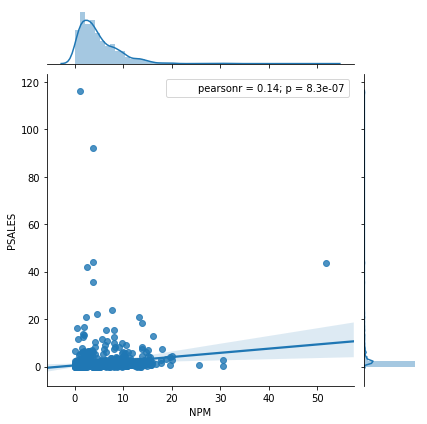

In [146]:
g = sns.jointplot(x = df['NPM'], y = df['PSALES'],kind="reg")

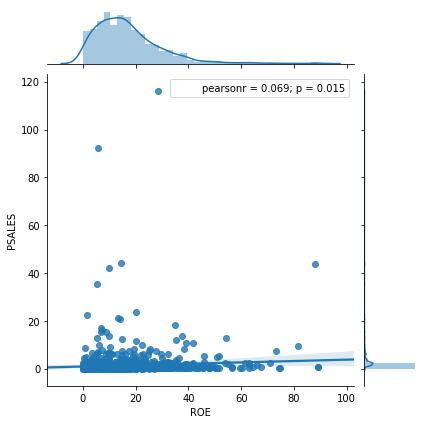

In [147]:
g = sns.jointplot(x = df['ROE'], y = df['PSALES'],kind="reg")

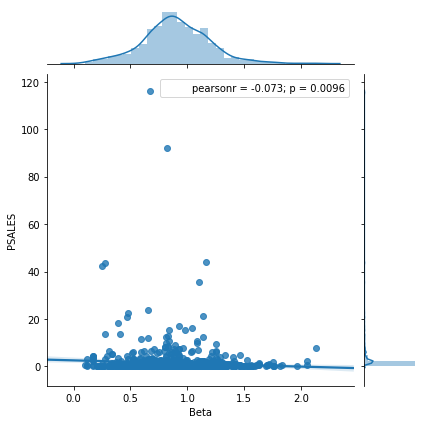

In [148]:
g = sns.jointplot(x = df['Beta'], y = df['PSALES'],kind="reg")

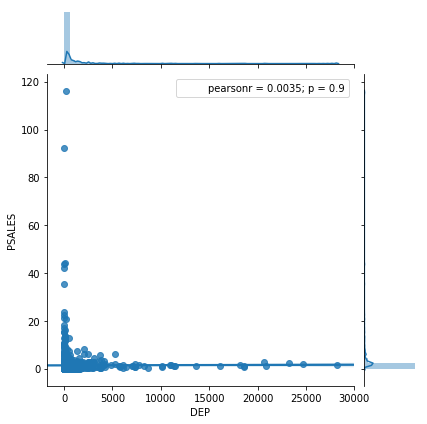

In [149]:
g = sns.jointplot(x = df['DEP'], y = df['PSALES'],kind="reg")

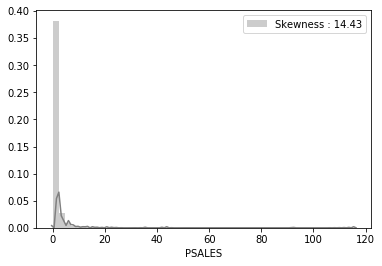

In [150]:
g = sns.distplot(df['PSALES'],color="gray")
g = g.legend(['Skewness : {:.2f}'.format(df['PSALES'].skew())],loc='best')

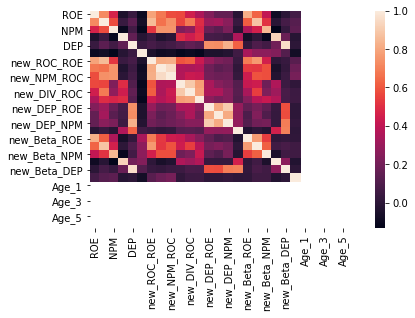

In [151]:
corrmat = df.corr()
g = sns.heatmap(df.corr())

# Transformation

In [61]:
df['PSALES'] = np.log1p(df['PSALES'])
Y = df['PSALES']
df = df.drop(labels="PSALES",axis = 1)

In [65]:
# Normalize data 
#N = Normalizer()
N = RobustScaler()

N.fit(df)

df = N.transform(df)

In [66]:
train_len = len(df)

In [67]:
## Separate train dataset 
X_train = df[:train_len]

In [68]:
lassocv = LassoCV(eps=1e-7) 
ridge = Ridge(alpha=1e-6) 
lassolarscv = LassoLarsCV()
elasticnetcv = ElasticNetCV(eps=1e-15)

In [69]:
###### Train classifiers
Y_train = Y[:train_len]

# 6.1.1 Cross validate models

In [70]:
# Regression linear models (Lasso, Ridge, Elasticnet)
def RMSE(estimator,X_train, Y_train, cv=5,n_jobs=4):
    cv_results = cross_val_score(estimator,X_train,Y_train,cv=cv,scoring="neg_mean_squared_error",n_jobs=n_jobs)
    return (np.sqrt(-cv_results)).mean()

In [71]:
RMSE(lassocv, X_train, Y_train)

0.54322151735172408

In [72]:
RMSE(ridge, X_train, Y_train)

0.5432922046159786

In [73]:
RMSE(lassolarscv, X_train, Y_train)

0.54338699839896054

In [74]:
RMSE(elasticnetcv, X_train, Y_train)

/root/miniconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/root/miniconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/root/miniconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.

/root/miniconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very

0.5430631842598701

In [75]:
lassocv.fit(X_train,Y_train)
ridge.fit(X_train,Y_train)
lassolarscv.fit(X_train,Y_train)
elasticnetcv.fit(X_train,Y_train)

/root/miniconda2/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



ElasticNetCV(alphas=None, copy_X=True, cv=None, eps=1e-15, fit_intercept=True,
       l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

# Features coefficients

In [76]:
print("LassoCV regression has conserved %d features over %d"%(len(features[lassocv.coef_!=0]),X_train.shape[1]))
print("Ridge regression has conserved %d features over %d"%(len(features[ridge.coef_!=0]),X_train.shape[1]))
print("LassoLarsCV regression has conserved %d features over %d"%(len(features[lassolarscv.coef_!=0]) ,X_train.shape[1]))
print("ElasticNetCV regression has conserved %d features over %d"%(len(features[elasticnetcv.coef_!=0]),X_train.shape[1]))

LassoCV regression has conserved 6 features over 12
Ridge regression has conserved 6 features over 12
LassoLarsCV regression has conserved 6 features over 12
ElasticNetCV regression has conserved 6 features over 12


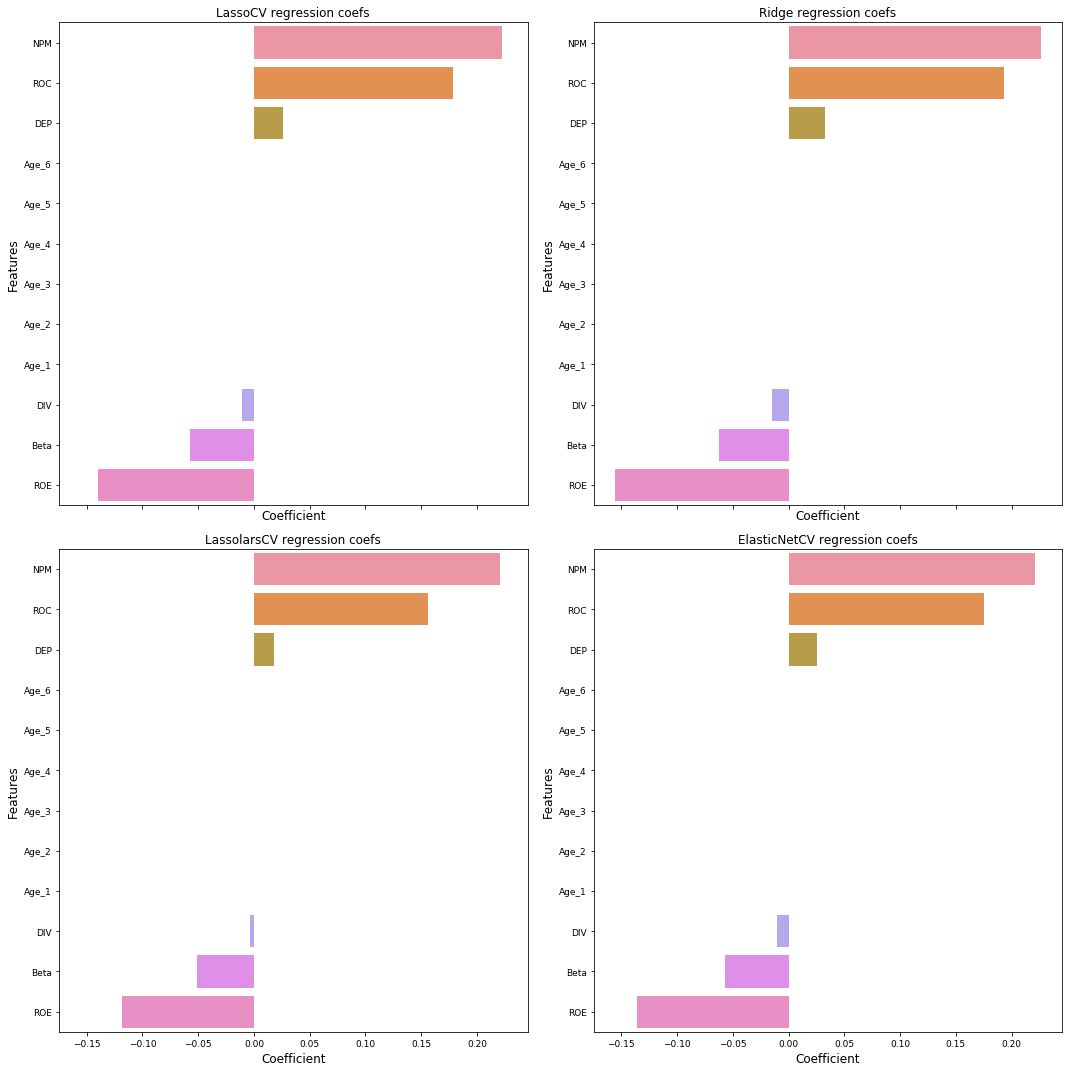

In [77]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_regressors = [("LassoCV", lassocv),("Ridge",ridge),("LassolarsCV",lassolarscv),("ElasticNetCV",elasticnetcv)]

nregressors = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_regressors[nregressors][0]
        regressor = names_regressors[nregressors][1]
        indices = np.argsort(regressor.coef_)[::-1][:40]
        g = sns.barplot(y=features[indices][:40],x = regressor.coef_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Coefficient",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " regression coefs")
        nregressors += 1
plt.tight_layout()
plt.show()
plt.gcf().clear()

In [78]:
Y_pred_lassocv = np.expm1(lassocv.predict(X_train))
Y_pred_lassolarscv = np.expm1(lassolarscv.predict(X_train))
Y_pred_elasticnetcv = np.expm1(elasticnetcv.predict(X_train))

# Tree based modeling

In [ ]:
# XGBoost

#model_xgb = xgb.XGBRegressor(n_estimators=3000, max_depth=2, learning_rate=0.1)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                             learning_rate=0.05, max_depth=6, 
                             min_child_weight=1.5, n_estimators=7200,
                             reg_alpha=0.9, reg_lambda=0.6,
                             subsample=0.2,seed=42, silent=1)

RMSE(model_xgb,X_train,Y_train)

In [45]:
model_xgb.fit(X_train,Y_train)
Y_pred_xgb = np.expm1(model_xgb.predict(X_train))

In [117]:
# Gradient Boosting
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
RMSE(GBoost,X_train,Y_train)

0.20245643726707402

In [118]:
GBoost.fit(X_train,Y_train)
Y_pred_GBoost = np.expm1(GBoost.predict(X_train))

In [120]:
# Light GBM
LightGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

RMSE(LightGB,X_train,Y_train)

0.16386332635420844

In [121]:
LightGB.fit(X_train,Y_train)
Y_pred_LightGB = np.expm1(LightGB.predict(X_train))

# Features importance

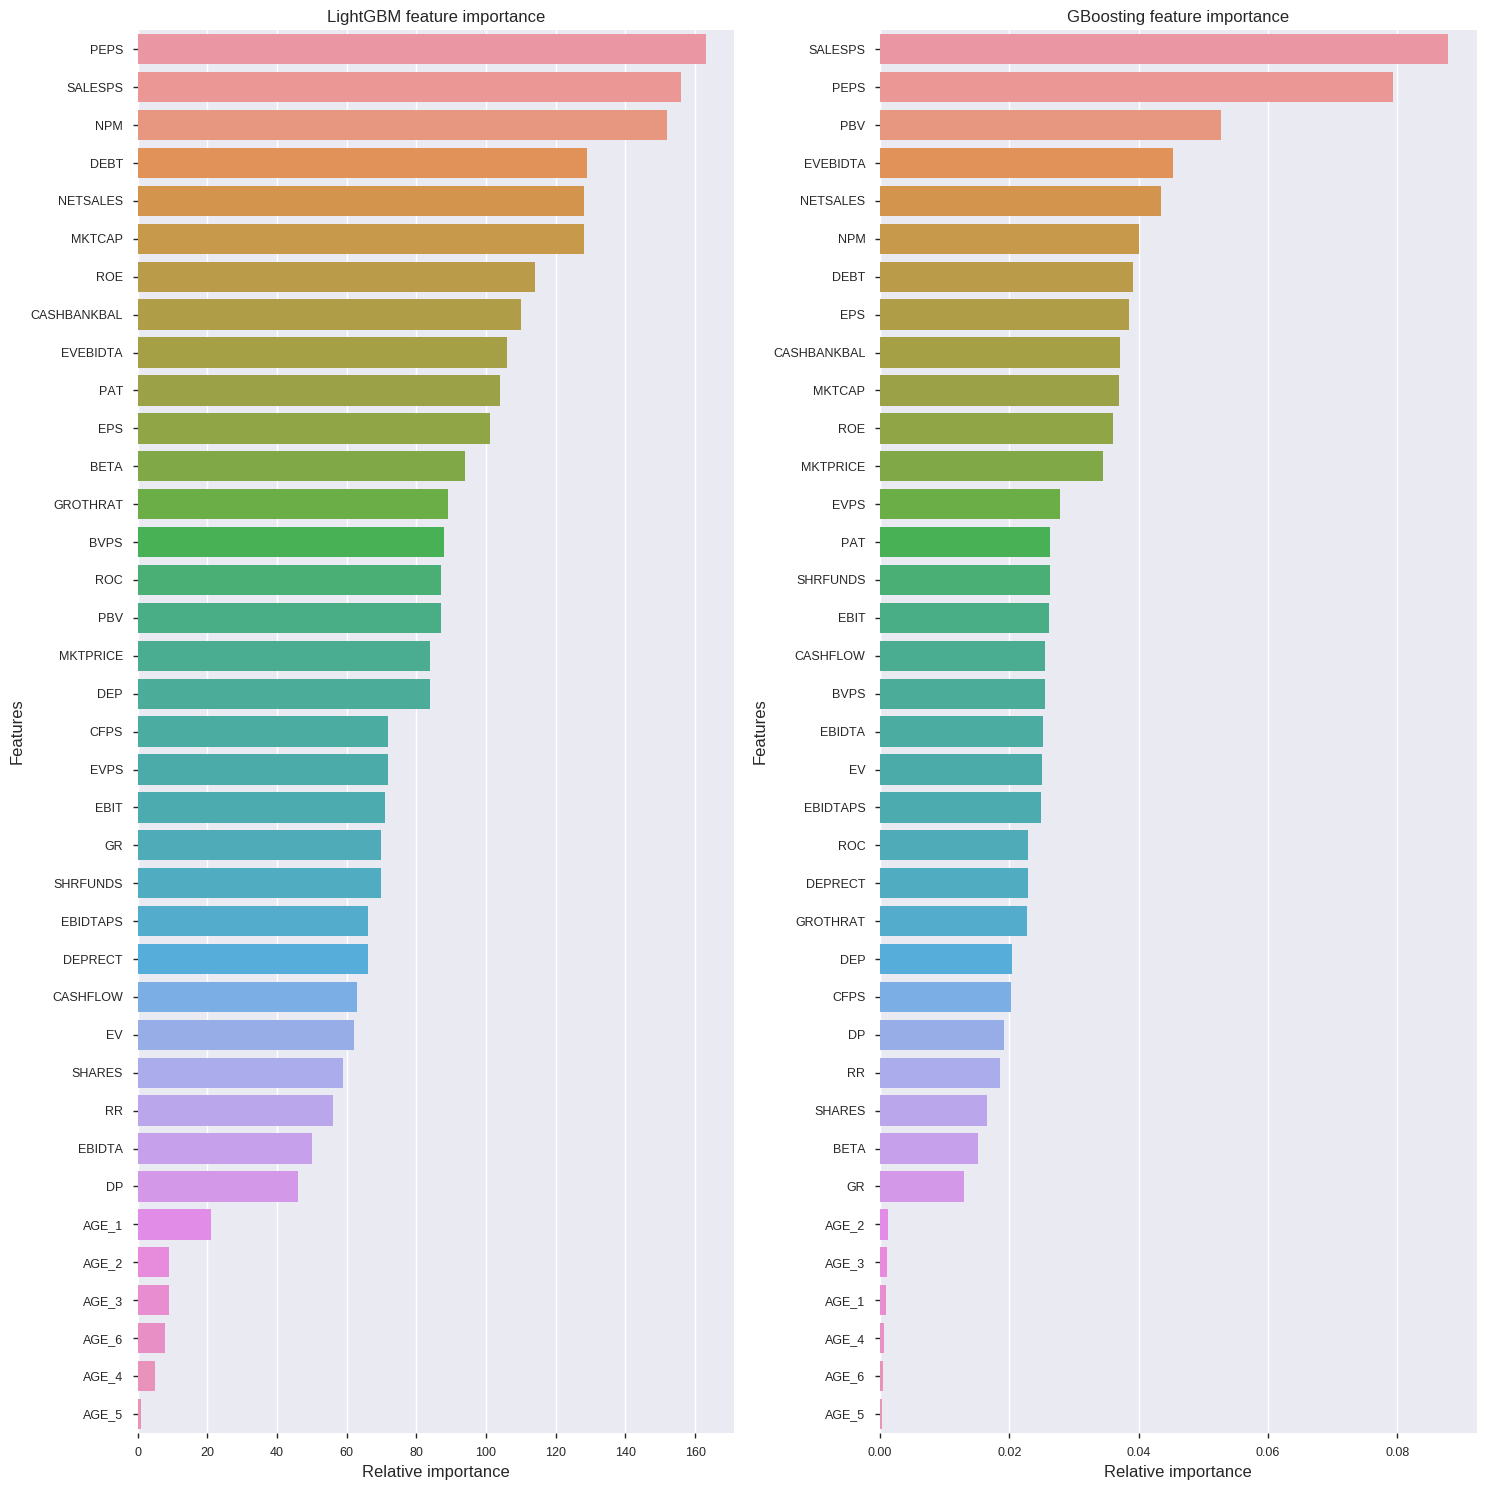

In [122]:
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15,15))

names_regressors = [("LightGBM",LightGB),("GBoosting",GBoost)]

nregressors = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_regressors[nregressors][0]
        regressor = names_regressors[nregressors][1]
        indices = np.argsort(regressor.feature_importances_)[::-1][:40]
        g = sns.barplot(y=features[indices][:40],x = regressor.feature_importances_[indices][:40] , orient='h',ax=axes[nregressors])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nregressors += 1

plt.tight_layout()
plt.show()
plt.gcf().clear()

# Learning Rate

In [ ]:
def plot_learning_curves(estimators, titles, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 4)):
    """Generate a simple plot of the test and training learning curve"""
    nrows = len(estimators)//2
    ncols = (len(estimators)//nrows)+ (0 if len(estimators) % nrows == 0 else 1)
    plt.figure(1)
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    
    n = 0
    for col in range(ncols):
        for row in range(nrows):
            estimator = estimators[n]
            title = titles[n]
            axes[row,col].set_title(title)
            
            if ylim is not None:
                axes[row,col].set_ylim(*ylim)
            
            axes[row,col].set_xlabel("Training examples")
            axes[row,col].set_ylabel("Score")
            
            train_sizes, train_scores, test_scores = learning_curve(estimator,
                    X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
                    scoring="neg_mean_squared_error")
    
            train_scores = np.sqrt(-train_scores)
            test_scores = np.sqrt(-test_scores)
    
            train_scores_mean = np.mean(train_scores, axis=1)
            train_scores_std = np.std(train_scores, axis=1)
            test_scores_mean = np.mean(test_scores, axis=1)
            test_scores_std = np.std(test_scores, axis=1)
            axes[row,col].grid()
        
            axes[row,col].fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
            axes[row,col].fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
            axes[row,col].plot(train_sizes, train_scores_mean, 'o-', color="r",
                     label="Training score")
            axes[row,col].plot(train_sizes, test_scores_mean, 'o-', color="g",
                     label="Cross-validation score")
            axes[row,col].legend(loc="best")
            
            n += 1
    plt.tight_layout()
    plt.show()
    plt.gcf().clear()

    

estimators = [lassocv,lassolarscv,elasticnetcv,GBoost,LightGB]
titles = ["LassoCV","LassoLarsCV","ElasticNet","Gradient Boosting","Light GBM"]

plot_learning_curves(estimators, titles, X_train, Y_train, cv=2 ,n_jobs=4)